<a href="https://colab.research.google.com/github/Uemerson/image-registration-tests/blob/main/voxelmorph_rgb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install necessary libs

In [1]:
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# install voxelmorph, which will also install dependencies: neurite and pystrum
!pip install voxelmorph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 108 kB 9.7 MB/s 


# Import necessary libs

In [3]:
# imports
import os, sys
import glob

# third party imports
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
assert tf.__version__.startswith('2.'), 'This tutorial assumes Tensorflow 2.0+'

# local imports
import voxelmorph as vxm
import neurite as ne

from google.colab import drive
import matplotlib.pyplot as plt  # Just so we can visually confirm we have the same images
%matplotlib inline
from PIL import Image

#Enabling and testing the GPU

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Connect with google drive

In [5]:
# mount drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Convert images to numpy arrays (npz)

In [6]:
colab_dataset_path = "/content/gdrive/My Drive/Colab Notebooks/image-registration/datasets"
train_images = []
val_images = []
# size = 1024, 1024
# size = 512, 512
# size = 256, 256
size = 128, 128

past_train_files = glob.glob(f'{colab_dataset_path}/past-unzip/train/*.jpg')
for past_train_file in past_train_files:
    current_train_file = past_train_file.replace(f'{colab_dataset_path}/past-unzip/train/', f'{colab_dataset_path}/current-unzip/train/')
    for file_path in [past_train_file, current_train_file]:
      train_image = Image.open(file_path)#.convert('L')
      train_image.thumbnail(size, Image.ANTIALIAS)
      train_images.append(np.array(train_image))

past_val_files = glob.glob(f'{colab_dataset_path}/past-unzip/val/*.jpg')
for past_val_file in past_val_files:
    current_val_file = past_val_file.replace(f'{colab_dataset_path}/past-unzip/val/', f'{colab_dataset_path}/current-unzip/val/')
    for file_path in [past_val_file, current_val_file]:
      val_image = Image.open(file_path)#.convert('L')
      val_image.thumbnail(size, Image.ANTIALIAS)
      val_images.append(np.array(val_image))

np.savez("train.npz", train=train_images)
np.savez("val.npz", val=val_images)

# Load dataset

In [7]:
train = np.load('train.npz')
val = np.load('val.npz')
x_train = train['train']
x_val = val['val']

print('type of x_train: {}, x_val: {}'.format(type(x_train), type(x_val)))
print('shape of x_train: {}, x_val: {}'.format(x_train.shape, x_val.shape))

type of x_train: <class 'numpy.ndarray'>, x_val: <class 'numpy.ndarray'>
shape of x_train: (50, 128, 128, 3), x_val: (50, 128, 128, 3)


# VoxelMorph

### Visualize Data

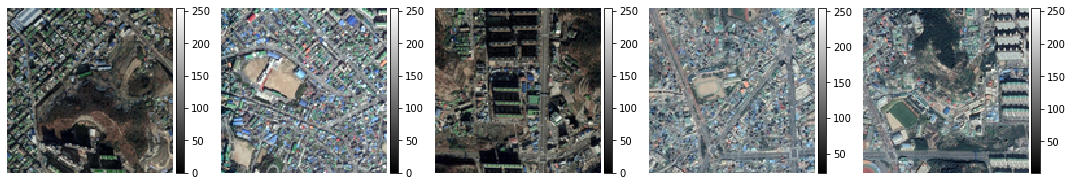

In [8]:
nb_vis = 5

# choose nb_vis sample indexes
idx = np.random.choice(x_train.shape[0], nb_vis, replace=False)
example_images = [f for f in x_train[idx, ...]]

# plot
ne.plot.slices(example_images, cmaps=['gray'], do_colorbars=True);

### Normalized

In [9]:
# fix data
x_train = x_train.astype('float')/255
x_val = x_val.astype('float')/255
# x_test = x_test.astype('float')/255

# verify
print('training maximum value', x_train.max())

training maximum value 1.0


### Re-visualize

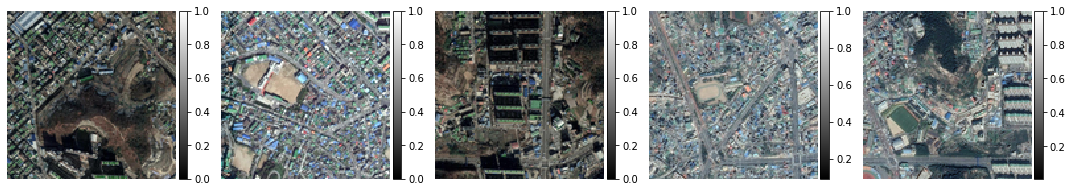

In [10]:
example_images = [f for f in x_train[idx, ...]]
ne.plot.slices(example_images, cmaps=['gray'], do_colorbars=True);

### Fix data

In [ ]:
# fix data
# pad_amount = ((0, 0), (0,0), (0, 0), (0,61))
# x_train = np.pad(x_train, pad_amount, 'constant')
# x_val = np.pad(x_val, pad_amount, 'constant')

# print('shape: ', x_train.shape)

### CNN Model

In [11]:
# configure unet features 
nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]

# build model using VxmDense
# inshape = x_train.shape[1:]
inshape = x_train.shape[1:-1]

# inshape = (512, 512, 3)
# inshape = (1024, 1024)
# inshape = (512, 512)
# inshape = (256, 256, 64)

# print(inshape)

# inshape=(128,128)

# src_feats
# trg_feats=3
# vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0, src_feats=3, trg_feats=3)
vxm_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0, src_feats=3, trg_feats=3)

print('input shape: ', ', '.join([str(t.shape) for t in vxm_model.inputs]))
print('output shape:', ', '.join([str(t.shape) for t in vxm_model.outputs]))

# voxelmorph has a variety of custom loss classes
losses = [vxm.losses.MSE().loss, vxm.losses.Grad('l2').loss]

# usually, we have to balance the two losses by a hyper-parameter
lambda_param = 0.05
loss_weights = [1, lambda_param]

vxm_model.compile(optimizer='Adam', loss=losses, loss_weights=loss_weights)

input shape:  (None, 128, 128, 3), (None, 128, 128, 3)
output shape: (None, 128, 128, 3), (None, 128, 128, 2)


### Train Model

In [17]:
def vxm_data_generator(x_data, batch_size=32):
    """
    Generator that takes in data of size [N, H, W], and yields data for
    our custom vxm model. Note that we need to provide numpy data for each
    input, and each output.

    inputs:  moving [bs, H, W, 1], fixed image [bs, H, W, 1]
    outputs: moved image [bs, H, W, 1], zero-gradient [bs, H, W, 2]
    """

    # preliminary sizing
    vol_shape = x_data.shape[1:] # extract data shape
    ndims = len(vol_shape)
    
    # prepare a zero array the size of the deformation
    # we'll explain this below
    zero_phi = np.zeros([batch_size, *vol_shape])
    
    while True:
        # prepare inputs:
        # images need to be of the size [batch_size, H, W, 1]
        idx1 = np.random.randint(0, x_data.shape[0], size=batch_size)
        moving_images = x_data[idx1, ...]
        idx2 = np.random.randint(0, x_data.shape[0], size=batch_size)
        fixed_images = x_data[idx2, ...]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # of course, we don't have this, but we know we want to compare 
        # the resulting moved image with the fixed image. 
        # we also wish to penalize the deformation field. 
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

(128, 128, 3)
(32, 128, 128, 3)


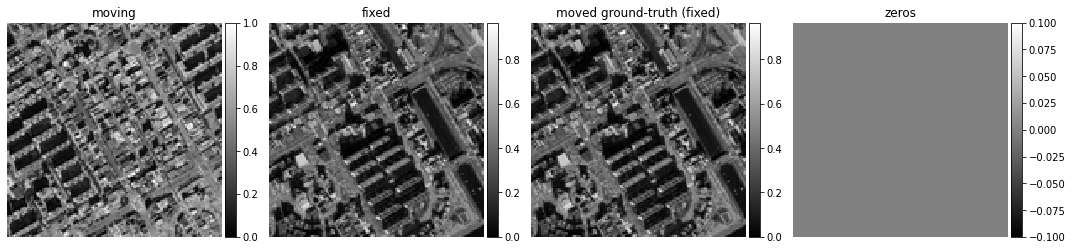

In [13]:
# let's test it
train_generator = vxm_data_generator(x_train)
in_sample, out_sample = next(train_generator)

# visualize
images = [img[0, :, :, 0] for img in in_sample + out_sample] 
titles = ['moving', 'fixed', 'moved ground-truth (fixed)', 'zeros']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

In [14]:
nb_epochs = 10
steps_per_epoch = 100
with tf.device('/device:GPU:0'):
  hist = vxm_model.fit_generator(train_generator, epochs=nb_epochs, steps_per_epoch=steps_per_epoch, verbose=2);

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


100/100 - 27s - loss: 0.0610 - vxm_dense_transformer_loss: 0.0594 - vxm_dense_flow_loss: 0.0330 - 27s/epoch - 268ms/step
Epoch 2/10
100/100 - 11s - loss: 0.0509 - vxm_dense_transformer_loss: 0.0459 - vxm_dense_flow_loss: 0.0998 - 11s/epoch - 106ms/step
Epoch 3/10
100/100 - 11s - loss: 0.0478 - vxm_dense_transformer_loss: 0.0418 - vxm_dense_flow_loss: 0.1212 - 11s/epoch - 105ms/step
Epoch 4/10
100/100 - 11s - loss: 0.0468 - vxm_dense_transformer_loss: 0.0401 - vxm_dense_flow_loss: 0.1327 - 11s/epoch - 106ms/step
Epoch 5/10
100/100 - 11s - loss: 0.0458 - vxm_dense_transformer_loss: 0.0388 - vxm_dense_flow_loss: 0.1406 - 11s/epoch - 106ms/step
Epoch 6/10
100/100 - 11s - loss: 0.0451 - vxm_dense_transformer_loss: 0.0378 - vxm_dense_flow_loss: 0.1473 - 11s/epoch - 106ms/step
Epoch 7/10
100/100 - 11s - loss: 0.0446 - vxm_dense_transformer_loss: 0.0371 - vxm_dense_flow_loss: 0.1513 - 11s/epoch - 107ms/step
Epoch 8/10
100/100 - 11s - loss: 0.0444 - vxm_dense_transformer_loss: 0.0366 - vxm_dens

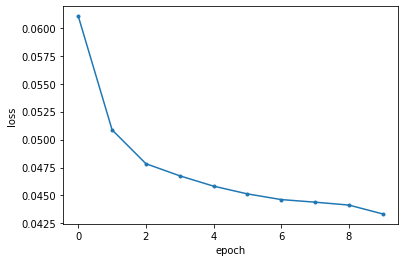

In [15]:
import matplotlib.pyplot as plt

def plot_history(hist, loss_name='loss'):
    # Simple function to plot training history.
    plt.figure()
    plt.plot(hist.epoch, hist.history[loss_name], '.-')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_history(hist)

### Registration

In [18]:
# let's get some data
val_generator = vxm_data_generator(x_val, batch_size = 1)
val_input, _ = next(val_generator)

val_pred = vxm_model.predict(val_input)

In [19]:
# %timeit is a 'jupyter magic' that times the given line over several runs
%timeit vxm_model.predict(val_input)

10 loops, best of 5: 40.6 ms per loop


### Visualize

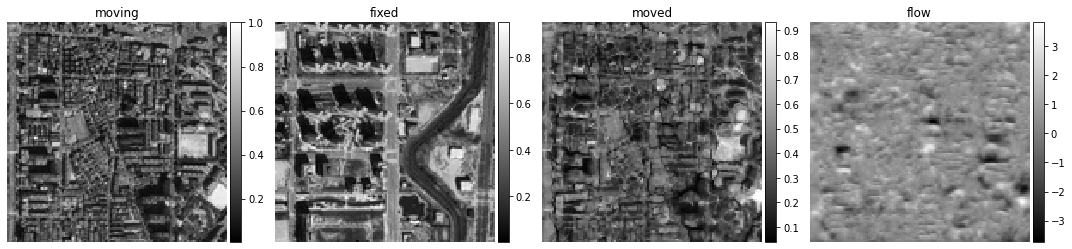

In [20]:
# visualize
images = [img[0, :, :, 0] for img in val_input + val_pred]
titles = ['moving', 'fixed', 'moved', 'flow']
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

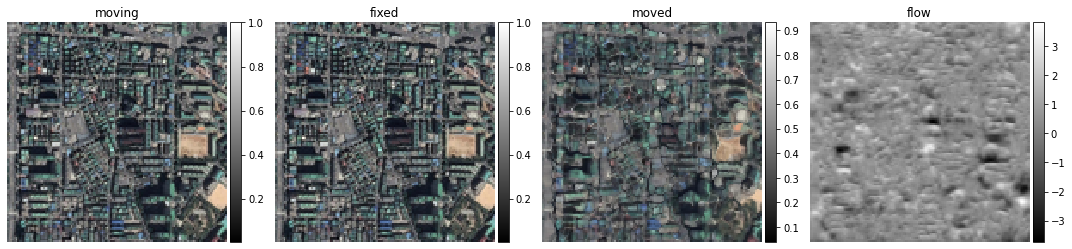

In [27]:
# visualize colored
moving_colored = val_input[0][0]
fixed_colored = val_input[0][0]
moved_colored = val_pred[0][0]
flow = [img[:, :, 0] for img in val_pred[1]]
titles = ['moving', 'fixed', 'moved', 'flow']

images = [moving_colored, fixed_colored, moved_colored, flow]
ne.plot.slices(images, titles=titles, cmaps=['gray'], do_colorbars=True);

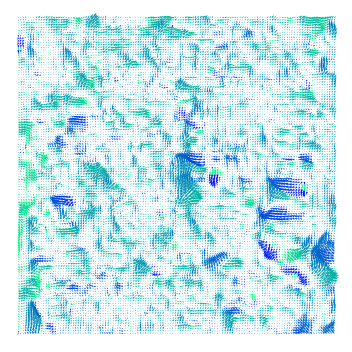

In [28]:
ne.plot.flow([val_pred[1].squeeze()], width=5);

### Dice Score

In [36]:
overlap = vxm.py.utils.dice(val_pred[0], val_input[1])
print('Dice: %.4f +/- %.4f' % (np.mean(overlap), np.std(overlap)))

Dice: 0.0000 +/- 0.0000
